# Tutorial (custom model)

You can define custom models to be tested in the state learner library. In this notebook, this is demonstrated with a DeepSurv neural network model.

In [9]:
import numpy as np
import pandas as pd
from pytmle import PyTMLE

In [10]:
target_times = [5.0, 10.0, 15.0, 20.0, 25.0]
np.random.seed(42)

Load the Hodgkin's Disease dataset.

In [11]:
df = pd.read_csv("hodgkins_disease.csv")

Define a custom model (exemplified by a model based on DeepSurv) to be cross-fitted in the .fit method.

In [12]:
# imports needed for pycox
import torchtuples as tt
from pycox.models import CoxPH

in_features = 7 # age, female, extranod, stage2, medwidsi_S, medwidsi_N, chemo
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


model = CoxPH(net, tt.optim.Adam)

Instantiate the PyTMLE class and fit it with both the DeepSurv model and a RandomSurvivalForest in the library of the state learner, and a support vector machine classifier + random forest in the library of the stacking classifier for propensity scores.

In [13]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

tmle = PyTMLE(df, 
              col_event_times="time", 
              col_event_indicator="status", 
              col_group="chemo", 
              target_times=target_times, 
              g_comp=True,
              verbose=3,)

tmle.fit(cv_folds=5, 
         max_updates=100, 
         save_models=True,
         models=[model, RandomSurvivalForest()],
         propensity_score_models=[SVC(), RandomForestClassifier()],
         labtrans=None)

Estimating propensity scores...
Estimating hazards and event-free survival...
Estimating censoring survival...
(CoxPH | CoxPH): 3.039067494120523
(CoxPH | RandomSurvivalForest): 3.0488997726124407
(RandomSurvivalForest | CoxPH): 3.2878747147243326
(RandomSurvivalForest | RandomSurvivalForest): 3.267161259846405
Starting TMLE update loop...
Step 1: Norm PnEIC improved to 0.02552972784702802.
Step 2: Norm PnEIC improved to 0.01879889731053828.
Step 3: Norm PnEIC improved to 0.013366134071044776.
Step 4: Norm PnEIC improved to 0.012506568462887686.
Step 5: Norm PnEIC improved to 0.011800513341399812.
Step 6: Norm PnEIC improved to 0.011189614114653643.
Step 7: Norm PnEIC improved to 0.01065846380412103.
Step 8: Norm PnEIC improved to 0.010202372383367327.
Step 9: Norm PnEIC improved to 0.009824646524712764.
Step 10: Norm PnEIC improved to 0.00954416156014202.
Step 11: Norm PnEIC improved to 0.009406644125445627.
Step 12: Norm PnEIC improved to 0.008857826295995429.
Step 13: Norm PnEIC imp

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='Predicted Risk'>,
        <Axes: title={'center': 'Event 2'}, xlabel='Time', ylabel='Predicted Risk'>],
       dtype=object))

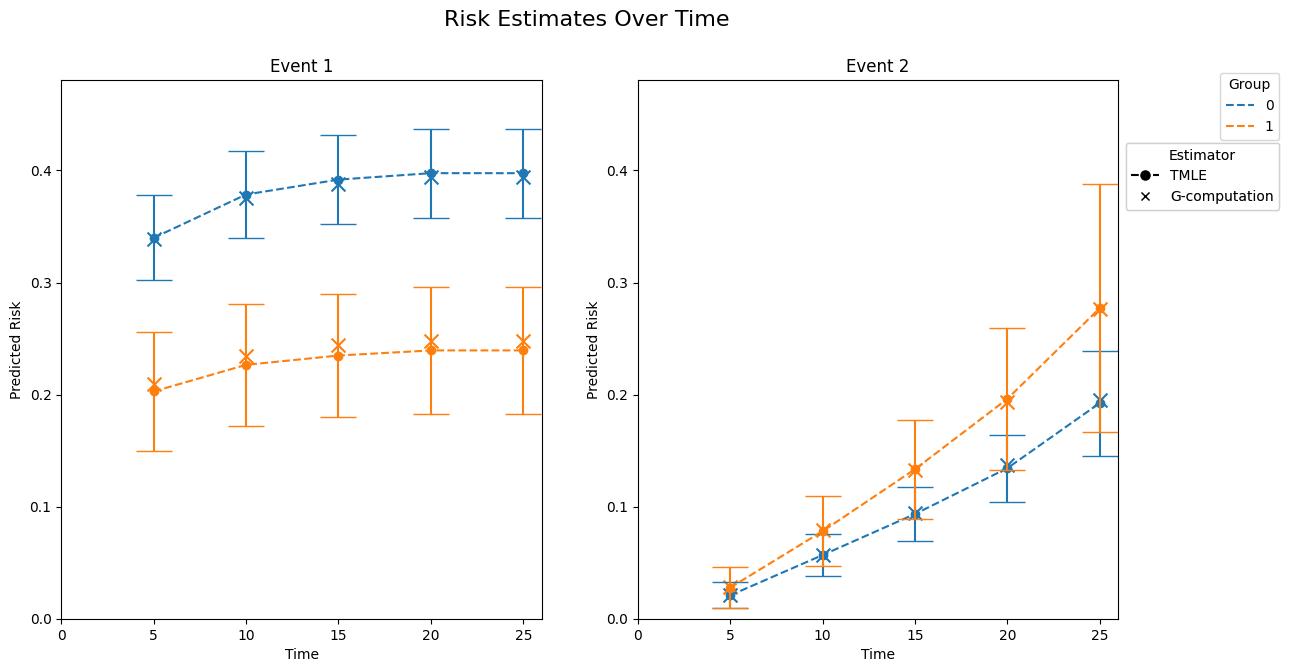

In [14]:
tmle.plot(g_comp=True, use_bootstrap=False)

Since `save_models` was set to `True` in the `fit()` call, you can extract the models used for initial estimates and analyze them further. Note that all cross-fitted models are of type `PycoxWrapper` and only return the name of the wrapped class.

In [15]:
print(tmle.models)
print(tmle.state_learner_cv_fit)

{'propensity_model': StackingClassifier(cv=5,
                   estimators=[('0', SVC()), ('1', RandomForestClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000)), 'risks_model_fold_0': CauseSpecificCoxPH, 'censoring_model_fold_0': CoxPH, 'risks_model_fold_1': CauseSpecificCoxPH, 'censoring_model_fold_1': CoxPH, 'risks_model_fold_2': CauseSpecificCoxPH, 'censoring_model_fold_2': CoxPH, 'risks_model_fold_3': CauseSpecificCoxPH, 'censoring_model_fold_3': CoxPH, 'risks_model_fold_4': CauseSpecificCoxPH, 'censoring_model_fold_4': CoxPH}
            risks_model       censoring_model      loss
0                 CoxPH                 CoxPH  3.039067
1                 CoxPH  RandomSurvivalForest  3.048900
3  RandomSurvivalForest  RandomSurvivalForest  3.267161
2  RandomSurvivalForest                 CoxPH  3.287875


You can see that the DeepSurv model was chosen for both risks and censoring.